# Síťová analýza: Vědecká korespondence v Británii 18.-19. století

V tomto notebooku si budeme prakticky osvojovat koncepty síťové analýzy. Z veřejně dostupných dat si vytvoříme několik síťových grafů, které budeme dále upravovat, analyzovat a vizualizovat.

Jedním z nejhodnotnějších typů historických dat jsou sbírky dopisů, které nám umožňují sledovat kdo, s kým a kdy udřžoval kontakty. Řada těchto dopisních sbírek byla v posledních dekádách digitalizována. Existují tak například digitalizované kolekce sbírkek dopisů středověkých žen (https://epistolae.ctl.columbia.edu/letters/) nebo rozsáhlá kolekce raně novověkých dopisů EMLO (=Early Modern Letters Online, http://emlo-portal.bodleian.ox.ac.uk/collections/?page_id=907#copyright). Některé tyto datasety umožňují přístup pouze pomocí prohlížeče, a tudíž se nehodí pro datově analytickou práci. Jiné jsou naopak vzorovými příklady datového kurátorství. Ty zde budeme používat.

Konkrétně využijeme dataset dopisů mezi britskými vědci konce 18. a celého 19. století **Ɛpsilon** ([web](https://epsilon.ac.uk)), vyvíjený týmem z *Cambridge University Digital Library*. 
> Ɛpsilon opens up new research opportunities in the history of 19th century science by bringing correspondence data and transcriptions from multiple sources into a single cross-searchable digital platform. It currently holds details of over 50,000 letters and is growing. 

Alespoň z pohledu datové analýzy je velkou devízou tohoto projektu fakt, že veškerá data jsou dostupná nejen pro potřeby prohledávání a pročítání na webu projektu, ale také ve velice úhledné a praktické formě dostupná na GitHubu ([zde](https://github.com/cambridge-collection/epsilon-data)). Nachází se zde jak digitální edice každého jednotlivého dopisu podle standardu TEI-XML, tak i tabulky metadat ve formátu CSV. S těmi budeme níže pracovat my, když se je přímo z GitHubu načteme do našeho výpočetního prostředí. 

Nejprve budeme pracovat s kolekcí dopisů *Londínské Linneovské společnosti*, která byla založena roku 1788 a existuje dodnes  ([wikipedia](https://en.wikipedia.org/wiki/Linnean_Society_of_London)). Ač nese jméno významného švédského vědce Carla Linného ([wikipedia](https://cs.wikipedia.org/wiki/Carl_Linné)), otce vědecké taxonomie, tato vědecká společnost vznikla v Anglii až po jeho smrti.  

Tabulková data budeme zpracovávat pomocí knihovny **pandas**. K síťové analýze využijeme knihovnu **networkX**, jejíž dokumentaci doporučuji k projití si - [zde](https://networkx.org/documentation/stable/index.html)).

## Korespondence Linnevské společnosti

### Extrakce a přehled dat

In [2]:
import numpy as np
import pandas as pd
import requests
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# navštívíme url adresu, kde jsou umístěny všechny csv soubory
# načteme HTTP odpověď do JSON formátu (není možné vždy, ale zde to funguje
resp_json = requests.get("https://github.com/cambridge-collection/epsilon-data/tree/main/csv").json()

Nyní si vypíšeme obsah načtených dat a zorientujeme v příslušné struktuře:

In [4]:
resp_json

{'payload': {'allShortcutsEnabled': False,
  'path': 'csv',
  'repo': {'id': 542535762,
   'defaultBranch': 'main',
   'name': 'epsilon-data',
   'ownerLogin': 'cambridge-collection',
   'currentUserCanPush': False,
   'isFork': False,
   'isEmpty': False,
   'createdAt': '2022-09-28T10:35:52.000Z',
   'ownerAvatar': 'https://avatars.githubusercontent.com/u/60095854?v=4',
   'public': True,
   'private': False,
   'isOrgOwned': True},
  'currentUser': None,
  'refInfo': {'name': 'main',
   'listCacheKey': 'v0:1664380801.622886',
   'canEdit': False,
   'refType': 'branch',
   'currentOid': 'a67ad584aa6afd616b88ef73e41c1d9d487591c1'},
  'tree': {'items': [{'name': 'ampere.csv',
     'path': 'csv/ampere.csv',
     'contentType': 'file'},
    {'name': 'darwin-correspondence.csv',
     'path': 'csv/darwin-correspondence.csv',
     'contentType': 'file'},
    {'name': 'darwin-family-letters.csv',
     'path': 'csv/darwin-family-letters.csv',
     'contentType': 'file'},
    {'name': 'farada

Vidíme, že ve struktuře je možné nalézt výpis jednotlivých `csv` souborů, které nás zajímají - nacházejí se pod tagem `"tree"`, ten je však zanořen v dalších tagách.

In [5]:
resp_json["payload"]["tree"]["items"]

[{'name': 'ampere.csv', 'path': 'csv/ampere.csv', 'contentType': 'file'},
 {'name': 'darwin-correspondence.csv',
  'path': 'csv/darwin-correspondence.csv',
  'contentType': 'file'},
 {'name': 'darwin-family-letters.csv',
  'path': 'csv/darwin-family-letters.csv',
  'contentType': 'file'},
 {'name': 'faraday.csv', 'path': 'csv/faraday.csv', 'contentType': 'file'},
 {'name': 'henslow.csv', 'path': 'csv/henslow.csv', 'contentType': 'file'},
 {'name': 'herschel.csv', 'path': 'csv/herschel.csv', 'contentType': 'file'},
 {'name': 'kemp.csv', 'path': 'csv/kemp.csv', 'contentType': 'file'},
 {'name': 'linnean-society.csv',
  'path': 'csv/linnean-society.csv',
  'contentType': 'file'},
 {'name': 'royal-society.csv',
  'path': 'csv/royal-society.csv',
  'contentType': 'file'},
 {'name': 'somerville.csv',
  'path': 'csv/somerville.csv',
  'contentType': 'file'},
 {'name': 'tyndall.csv', 'path': 'csv/tyndall.csv', 'contentType': 'file'}]

In [6]:
filenames = [item["name"] for item in resp_json["payload"]["tree"]["items"]]
filenames

['ampere.csv',
 'darwin-correspondence.csv',
 'darwin-family-letters.csv',
 'faraday.csv',
 'henslow.csv',
 'herschel.csv',
 'kemp.csv',
 'linnean-society.csv',
 'royal-society.csv',
 'somerville.csv',
 'tyndall.csv']

In [7]:
linnean = pd.read_csv("https://raw.githubusercontent.com/cambridge-collection/epsilon-data/main/csv/linnean-society.csv")
linnean.head()

,id,sender_surname,sender_forename,recipient_surname,recipient_forename,sorting_date,date,sender_address,recipient_address,source,languages,extent,filename
0,LINNEAN1,Abbot,Charles,Smith,Sir James Edward,1807-11-02,2 Nov 1807,"Bedford, Bedfordshire",NaN,"GB-110/JES/ADD/1, The Linnean Society of London",eng,NaN,LINNEAN1.xml
1,LINNEAN2,Butt,John Martin,Smith,Sir James Edward,1798-09-17,17 Sep 1798,"Witley, Worcestershire",NaN,"GB-110/JES/ADD/10, The Linnean Society of London",eng,NaN,LINNEAN2.xml
2,LINNEAN3,Strutt,Jacob George,Smith,Sir James Edward,1826-05-31,31 May 1826,London,NaN,"GB-110/JES/ADD/100, The Linnean Society of London",eng,NaN,LINNEAN3.xml
3,LINNEAN4,Swainson,William,Smith,Sir James Edward,1815-04-22,22 Apr 1815,"Palermo, Sicily",London,"GB-110/JES/ADD/101, The Linnean Society of London",eng,NaN,LINNEAN4.xml
4,LINNEAN5,Teesdale,Robert,Smith,Sir James Edward,1789-11-18,18 Nov 1789,London,London,"GB-110/JES/ADD/102, The Linnean Society of London",eng,NaN,LINNEAN5.xml


Vidíme zde výpis prvních pěti řádek datové tabulky. Ale kolik vlastně tabulka čítá položek a kolik že je sloupců? To zjistíme z atributu `shape` (atributem je vlastnost datového objektu - jednou z vlastností datového objektu podle standardu `pd.DataFrame` je jeho tvar, tj. počet řádků a sloupců. 

In [8]:
linnean.shape

(3538, 13)

Než se pustíme do síťových analýz, ještě si upravíme hodnoty v některých sloupcích tak, aby se nám s nimi dobře pracovalo. Sloupec `"sorting_date"` vyjadřuje dataci daného dopisu ve velice úhledném a srozumitelném formátu (yyyy-mm-dd). Jelikož jsme však naše data načetl z prostého `csv` souboru, Python neví nic o tom, že za touto řadou čísel a pomlček se jedná o dataci; k tomu jej musíme nainstruovat.

V buňce níže za tímto účelem vytváříme nový sloupec s výmluvným názvem `"datetime"`. Hodnoty v tomto sloupci jsou výsledkem použití (aplikování) funkce `to_datetime()` z knihovny pandas (`pd`) na hodnoty ve sloupci `"sorting_date"`. Tato funkce "přeloží" jednotlivá čísla na roky, měsíce a dny.

In [9]:
linnean["datetime"] = linnean["sorting_date"].apply(pd.to_datetime)
linnean.head(5)

,id,sender_surname,sender_forename,recipient_surname,recipient_forename,sorting_date,date,sender_address,recipient_address,source,languages,extent,filename,datetime
0,LINNEAN1,Abbot,Charles,Smith,Sir James Edward,1807-11-02,2 Nov 1807,"Bedford, Bedfordshire",NaN,"GB-110/JES/ADD/1, The Linnean Society of London",eng,NaN,LINNEAN1.xml,1807-11-02
1,LINNEAN2,Butt,John Martin,Smith,Sir James Edward,1798-09-17,17 Sep 1798,"Witley, Worcestershire",NaN,"GB-110/JES/ADD/10, The Linnean Society of London",eng,NaN,LINNEAN2.xml,1798-09-17
2,LINNEAN3,Strutt,Jacob George,Smith,Sir James Edward,1826-05-31,31 May 1826,London,NaN,"GB-110/JES/ADD/100, The Linnean Society of London",eng,NaN,LINNEAN3.xml,1826-05-31
3,LINNEAN4,Swainson,William,Smith,Sir James Edward,1815-04-22,22 Apr 1815,"Palermo, Sicily",London,"GB-110/JES/ADD/101, The Linnean Society of London",eng,NaN,LINNEAN4.xml,1815-04-22
4,LINNEAN5,Teesdale,Robert,Smith,Sir James Edward,1789-11-18,18 Nov 1789,London,London,"GB-110/JES/ADD/102, The Linnean Society of London",eng,NaN,LINNEAN5.xml,1789-11-18


Ač hodnoty ve sloupci `"datetime"` vypadají stejně jako hodnoty ve sloupci `"sorting_date"`, chovají se odlišně. Umožňují nám přímo studovat časovou distribuci našich dat. Výhody tohoto formátu si všimneme, když na daný sloupec aplikujeme vizualizační metodu `hist()`:

<Axes: >

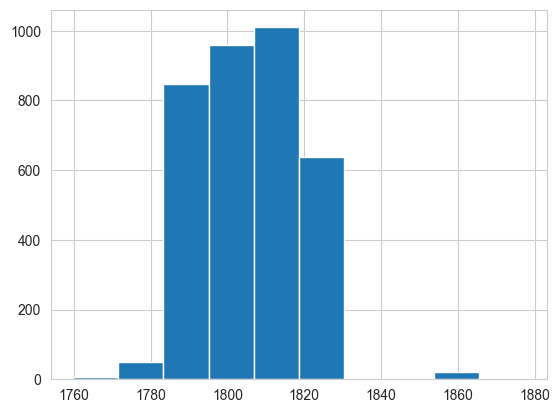

In [15]:
linnean["datetime"].hist()

In [16]:
linnean["18thcent?"] = linnean["datetime"] < pd.to_datetime("1801-01-01")

In [17]:
linnean["sender_agr"] = linnean.apply(lambda row: str(row["sender_surname"]).replace(" ", "_") + "_" + str(row["sender_forename"]).replace(" ", "_"), axis=1)

linnean["recipient_agr"] = linnean.apply(lambda row: str(row["recipient_surname"]).replace(" ", "_") + "_" + str(row["recipient_forename"]).replace(" ", "_"), axis=1)

Nyní se podíváme na osoby, který poslaly a přijaly největší množství dopisů:

In [80]:
linnean["sender_agr"].value_counts()

sender_agr
Smith_Sir_James_Edward       481
Goodenough_Samuel            222
Woodward_Thomas_Jenkinson    101
Roscoe_William                98
Johnes_Thomas                 84
                            ... 
Erskine_David_Steuart          1
Upcher_Abbot                   1
Walcott_William                1
Baker_William_Lloyd            1
Cullen_Charles_Sinclair        1
Name: count, Length: 457, dtype: int64

In [81]:
linnean["recipient_agr"].value_counts()

recipient_agr
Smith_Sir_James_Edward    2948
Macleay_Alexander          102
Smith_Pleasance             72
Roscoe_William              53
Unknown_nan                 51
                          ... 
Sutton_Charles               1
Brandreth_Mrs                1
Bright_Richard               1
Walker_George                1
Reeve_Robert                 1
Name: count, Length: 65, dtype: int64

V obou případech vidíme na prvním místě *Sira Jamese Edwarda Smithe*. Což, víme-li něco o Linneovské společnosti nebo podíváme-li se na wikipedii, není příliš překvapivé: jedná se o samotného zakladatele a dlouholetého předsedu této společnosti (viz [wikipedia](https://en.wikipedia.org/wiki/James_Edward_Smith_(botanist))).

V druhé tabulce vidíme na třetím místě také jeho manželku, *Pleasance Smithovou*, která byla taktéž významnou osobností dobového dění (taktéž viz [wikipedie](https://en.wikipedia.org/wiki/Pleasance_Smith)).  

### Tvorba síťových dat
Pro potřeby následujících si naše data výrazně přeskupíme a přetvoříme do podoby *seznamu vážených vazeb*.

In [20]:
linnean_edges = linnean.groupby(["sender_agr", "recipient_agr"]).size().reset_index()
linnean_edges.columns = ["sender_agr", "recipient_agr", "letters_n"]
linnean_edges.head()

,sender_agr,recipient_agr,letters_n
0,Abbot_Charles,Smith_Sir_James_Edward,18
1,Acharius_Erik,Smith_Sir_James_Edward,8
2,Acrel_Johan_Gustaf,Smith_Sir_James_Edward,7
3,Afzelius_Adam,Smith_Sir_James_Edward,14
4,Aiton_William_Townsend,Smith_Sir_James_Edward,1


Jednotkou pozorování (čili řádkou tabulky) nyní již není každý jednotlivý dopis, ale pár odesilatele a příjemce s informací, kolik odesilatel příjemci zaslal dopisů (viz sloupec `"letters_n"`). Můžeme podívat na tabulku hran setříděnou od těch s největší váhou (tj. s nejvyšším počtem dopisů poslaných daným směrem).

In [21]:
linnean_edges.sort_values("letters_n", ascending=False)

,sender_agr,recipient_agr,letters_n
189,Goodenough_Samuel,Smith_Sir_James_Edward,222
413,Smith_Sir_James_Edward,Macleay_Alexander,102
525,Woodward_Thomas_Jenkinson,Smith_Sir_James_Edward,101
348,Roscoe_William,Smith_Sir_James_Edward,94
241,Johnes_Thomas,Smith_Sir_James_Edward,83
...,...,...,...
352,Rous_Charlotte_Maria,Smith_Sir_James_Edward,1
353,Rowden_Frances_Arabella,Smith_Sir_James_Edward,1
158,Erskine_David_Steuart,Smith_Sir_James_Edward,1
157,Engelhart_John_Henry,Smith_Sir_James_Edward,1


In [101]:
G = nx.from_pandas_edgelist(linnean_edges, 'sender_agr', 'recipient_agr', 'letters_n', create_using=nx.DiGraph())

In [102]:
type(G)

networkx.classes.digraph.DiGraph

Základní vlastnosti, které nás o našem grafu zajímají jsou, kolik má uzlů a kolik má hran?

In [103]:
G.number_of_nodes()

476

In [104]:
G.number_of_edges()

534

Další užitečnou informací je, kolik mají uzle v průměru vazeb (tzv. avarege degree).

In [105]:
sum(dict(G.degree).values()) / G.number_of_nodes()

2.2436974789915967

Stejně tak zajímavé bude se podívat, který uzle mají nejvyšší *in-degree* (tj. vazeb do něj vstupujících) a *out-degree*
(tj. vazeb z něj vystupujících). Podívejme se na deset uzlů s nejvyšší hodnotou in-degree:

In [106]:
sorted(dict(G.in_degree()).items(), key=lambda item: item[1], reverse=True)[:10]

[('Smith_Sir_James_Edward', 445),
 ('Unknown_nan', 14),
 ('Smith_Pleasance', 6),
 ('Cullum_Sir_Thomas_Gery', 4),
 ('Lambert_Aylmer_Bourke', 2),
 ('Wallich_Nathaniel', 2),
 ('Goodenough_Samuel', 2),
 ('The_Linnean_Society_nan', 2),
 ('Banks_Sir_Joseph', 1),
 ('Barrington_Shute', 1)]

Vidíme, že zcela ústřední pozici zde zaujímá *Sir James Edward Smith*, zakladatel a dlouholetý předseda společnosti. Hned na druhém místě se v jednom uzlu potkávají dopisy, jejichž adresát je neznámý. Nebude od věci tento uzel ze sítě zcela odstranit.

In [108]:
G.remove_node("Unknown_nan")

Utvořený síťový graf si můžeme bezprostřdně vizualizovat pomocí funkce `nx.draw()`:

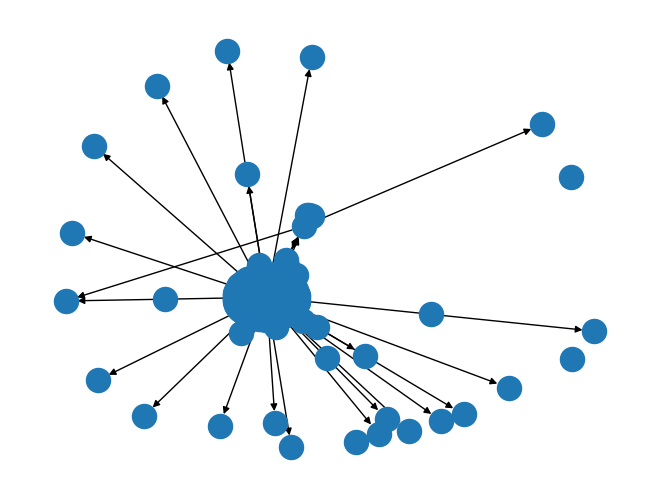

In [111]:
nx.draw(G)

Bohužel vidíme, že výsledek vypadá spíše nevábně. Podle všeho se zde příliš mnoho uzlů poblíž středu. Vidíme, že vazby mají podobu šipek. Je tomu tak proto, že se jedná o tzv. směrový graf.

Abychom dosáhli lepších výsledků, přidáme do vizualizační funkce několik dodatečných parametrů

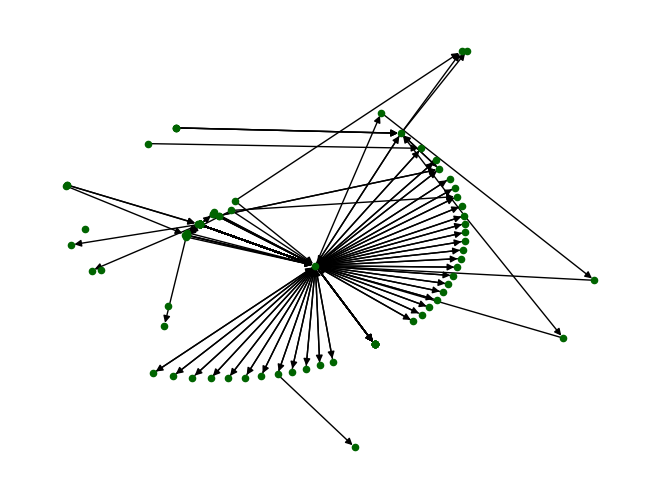

In [112]:
nx.draw(G, node_size=20, node_color="darkgreen", pos=nx.kamada_kawai_layout(G))

Uzly v  grafu se jmenují stejně jako korespondenti. Pomocí syntaxe níže se tak můžeme podívat na vlastnosti jednotlivých vazeb. 

In [113]:
G["Smith_Sir_James_Edward"]["Macleay_Alexander"]

{'letters_n': 102}

In [114]:
G["Macleay_Alexander"]["Smith_Sir_James_Edward"]


{'letters_n': 74}

Zde se dozvídáme, že zatímco Sir James Edward Smith poslal Alexanderu Macleayovi 102, v opačném směru jich šlo 74.

Pro některé typy analýz je praktičtější i smysluplnější pracovat s nesměrovým grafem. Vazba tak nezohledňuje směr příslušné korespondence a váha může odpovídat součtu vyměněných dopisů v obou směrech. Transformovat naši síť do této podoby vyžaduje několik řádek kódy, jimiž se zde nemusíme příliš zaobírat, důležitější je výsledek.

In [115]:
to_remove = []
edges_met = []
for node1, node2 in G.edges():
    if (G.has_edge(node2, node1)) & ((node2, node1) not in edges_met):
        G[node1][node2]["letters_n"] = G[node1][node2]["letters_n"] + G[node2][node1]["letters_n"]
        to_remove.append((node2, node1))
    edges_met.append((node1, node2))

In [116]:
len(edges_met)

519

In [117]:
len(to_remove)

35

In [118]:
for u,v in to_remove:
    G.remove_edge(u,v)

In [119]:
G = G.to_undirected().copy()

In [120]:
len(G.edges())

484

In [121]:
G["Smith_Sir_James_Edward"]["Macleay_Alexander"]

{'letters_n': 176}

In [122]:
G["Macleay_Alexander"]["Smith_Sir_James_Edward"]

{'letters_n': 176}

In [123]:
weighted_degrees = {}
for node in G.nodes():
    weighted_degrees[node] = G.degree(node, weight='letters_n')

In [127]:
weighted_degrees

{'Abbot_Charles': 18,
 'Smith_Sir_James_Edward': 3418,
 'Acharius_Erik': 8,
 'Acrel_Johan_Gustaf': 7,
 'Afzelius_Adam': 14,
 'Aiton_William_Townsend': 1,
 'Allioni_Carlo': 7,
 'Anderson_Alexander': 2,
 'Anderson_James': 2,
 'Anguish_Mrs_S': 1,
 'Annesley_George': 19,
 'Anonymous_nan': 1,
 'Anstruther_Sir_John': 1,
 'Arnott_George_Arnold_Walker': 1,
 'Aufrere_Anthony': 1,
 'Babington_William': 2,
 'Backhouse_James': 2,
 'Bagg_C_J': 1,
 'Baillie_Matthew': 8,
 'Bainbridge_J_H': 1,
 'Baker_J': 1,
 'Baker_John': 2,
 'Baker_Richard': 2,
 'Baker_William_Lloyd': 1,
 'Balbis_Giovanni_Battista': 1,
 'Baldwin_John': 2,
 'Baldwin_William': 2,
 'Banfather_Henry': 1,
 'Banks_Sir_Joseph': 52,
 'Barclay_Robert': 3,
 'Barker_Edmund_Henry': 5,
 'Barnwell_Frederick_Henry_Turnor': 1,
 'Barrington_Jane': 13,
 'Lambert_Aylmer_Bourke': 81,
 'Barrington_Shute': 8,
 'Bateman_James': 1,
 'Beadon_Richard': 1,
 'Sutton_Charles': 3,
 'Beattie_James': 3,
 'Beeke_Henry': 3,
 'Bellardi_Carlo_Antonio_Ludovico': 12,
 '

In [130]:
# tento degree učiníme atributem našich uzlů
nx.set_node_attributes(G, weighted_degrees, 'weighted_degree')

Nyní si vyjmeme pouze uzly, které mají stupeň alespoň roven 2, tj. uzly osob, kteří v našem datasetu vedly korespondenci s více než jednou osobou.

In [131]:
node_list = [node for node in G.nodes if G.degree(node) >= 2]
len(node_list)

28

Ukazuje se, že takových uzlů je v našem datasetu relativně málo. Vypišme si jejich jména.

In [133]:
node_list

['Smith_Sir_James_Edward',
 'Barrington_Jane',
 'Lambert_Aylmer_Bourke',
 'Sutton_Charles',
 'Bicheno_James_Ebenezer',
 'Forster_Edward',
 'Boyd_George',
 'Roxburgh_William',
 'Brodie_James',
 'Coke_Thomas_William',
 'Wallich_Nathaniel',
 'Crowe_James',
 'Cullum_Sir_Thomas_Gery',
 'Smith_Pleasance',
 'Davy_Martin',
 'Don_George',
 'Goodenough_Samuel',
 'Drake_William_Fitt',
 'Gemmellaro_Carlo',
 'The_Linnean_Society_nan',
 'Gurney_Anna',
 'Harriman_John',
 'Johnes_Thomas',
 'Latham_John',
 'Martyn_Thomas',
 'Smith_James',
 'Swartz_Olof_Peter',
 'Webb_William']

Nyní tento seznam jmen využijeme k vymezení výseku z našeho grafu (nazveme si jej `Gsub`), který bude zahrnovat pouze tyto uzly. 

In [134]:
Gsub = G.subgraph(node_list)

(-1.3, 1.3)

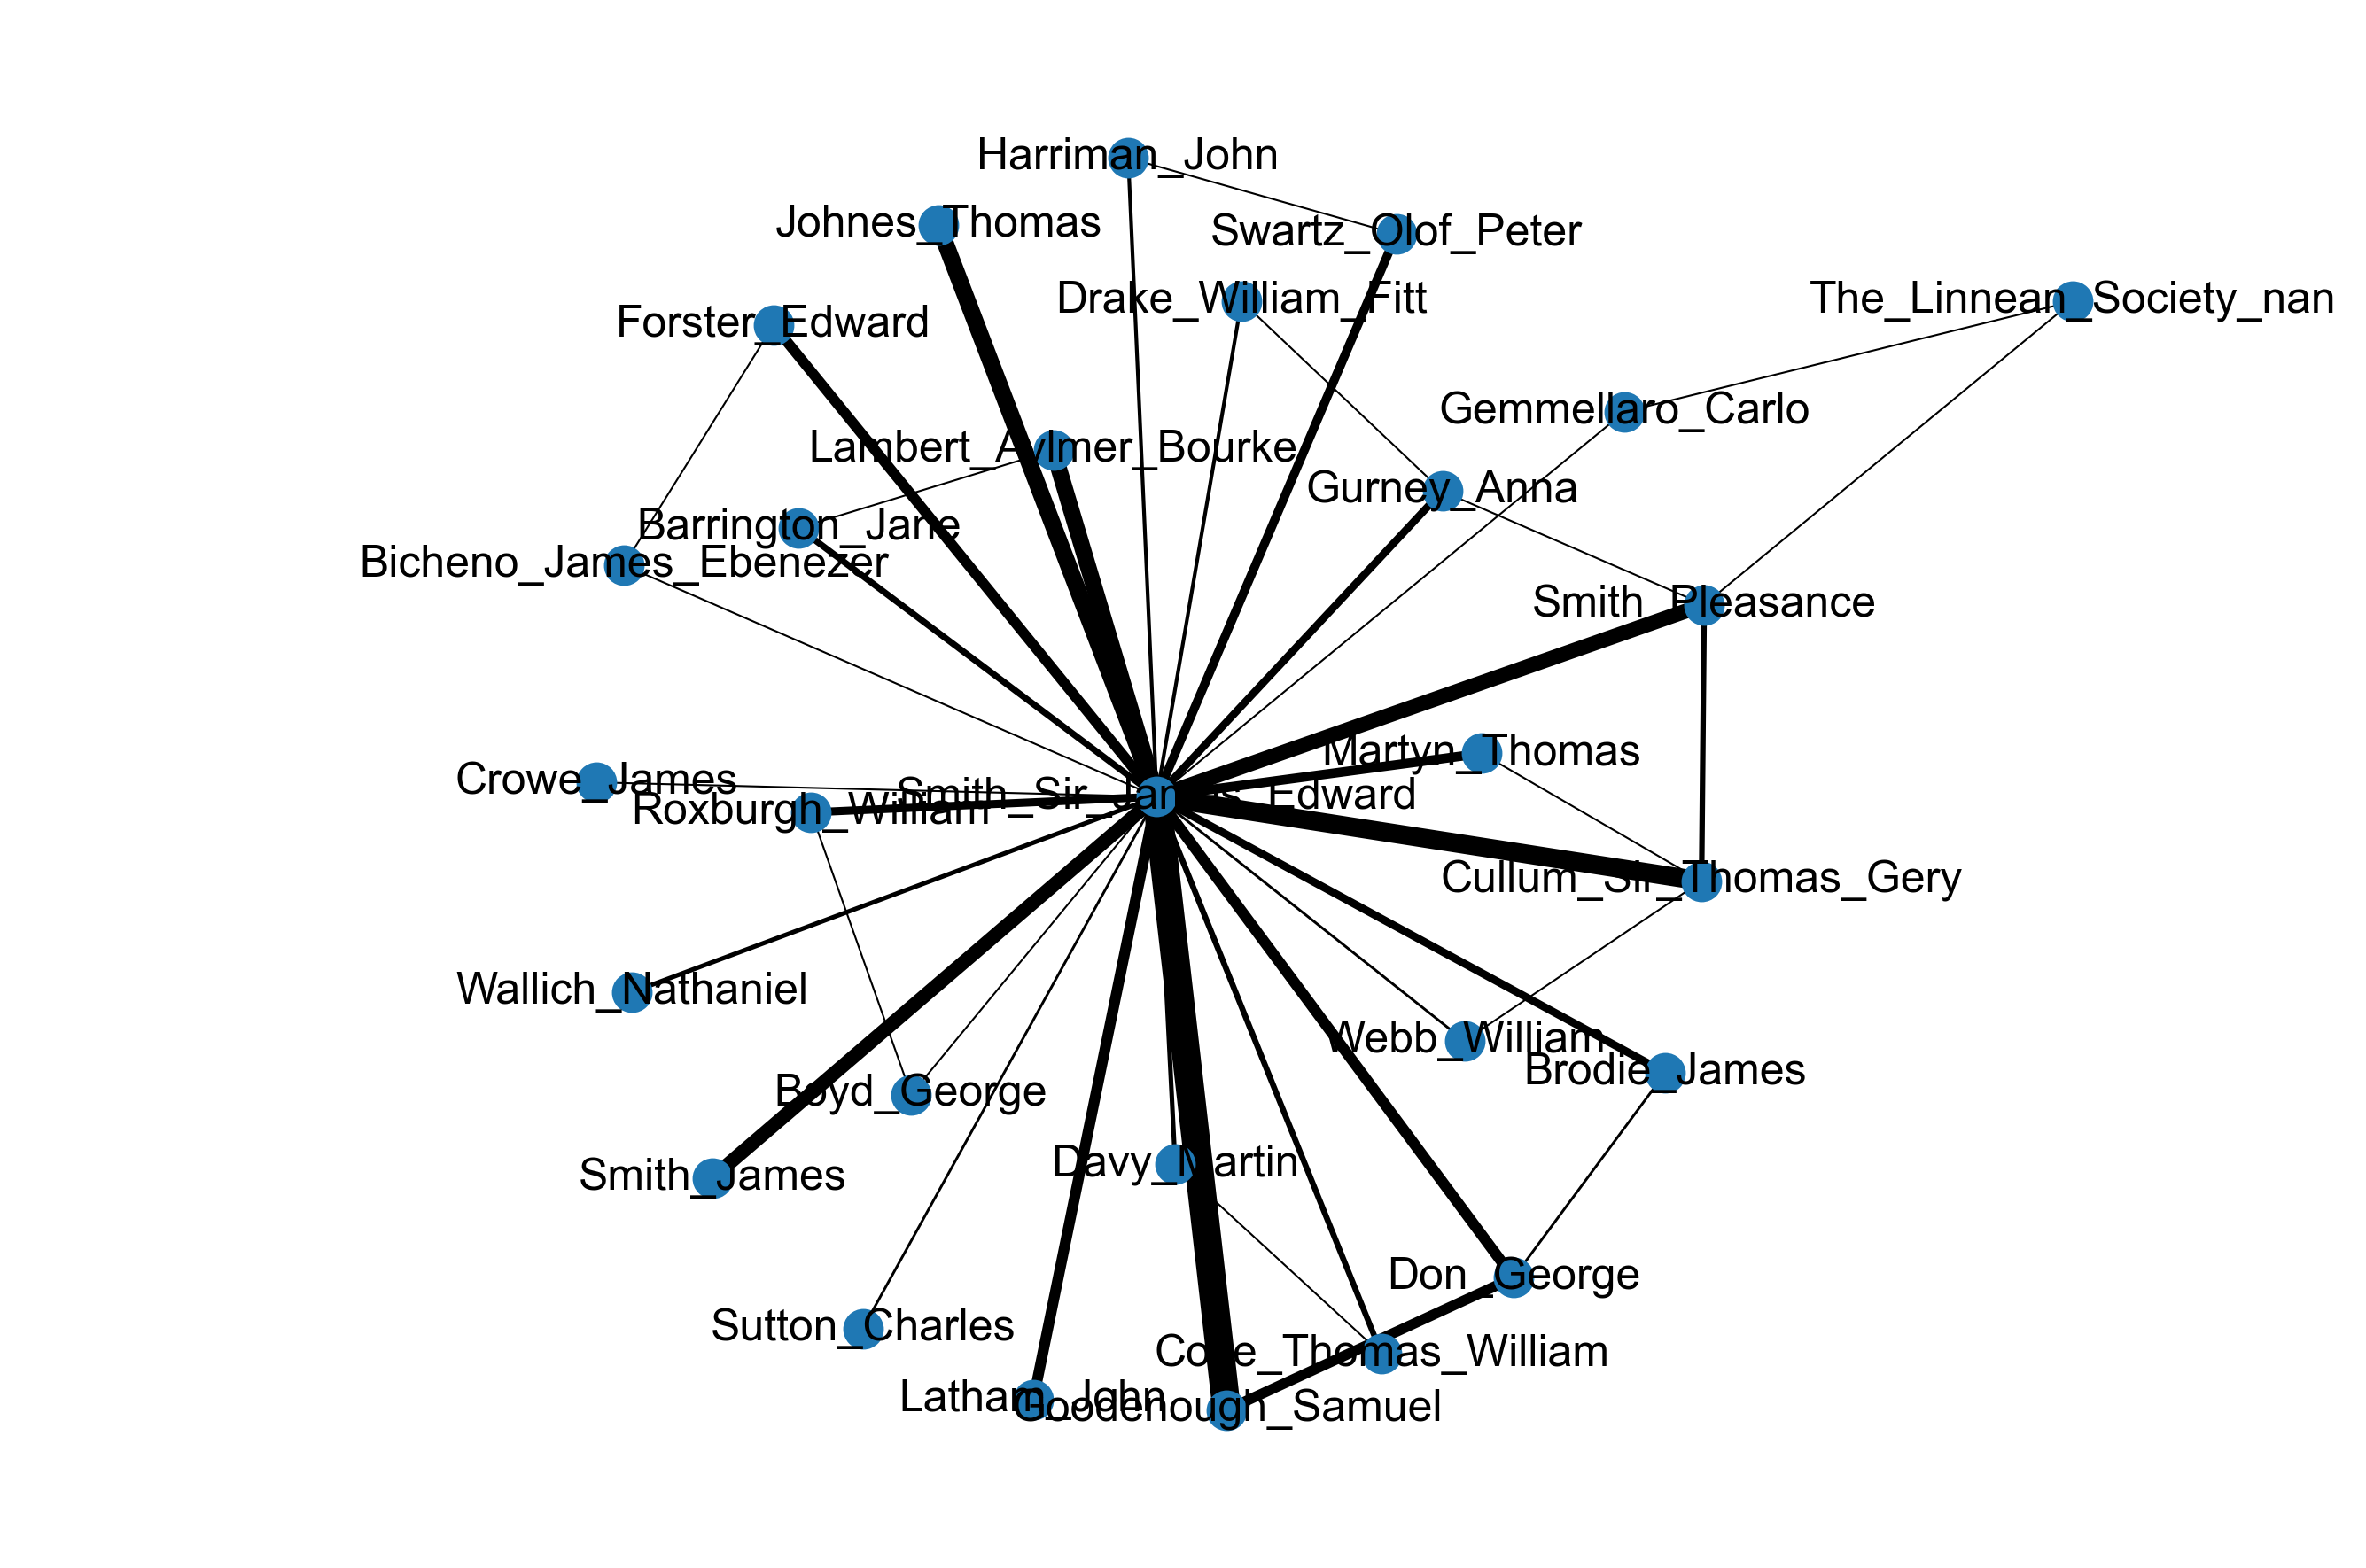

In [140]:
fig, ax = plt.subplots(1,1, figsize=(9, 6), dpi=300, tight_layout=True)

# pro potřeby vizualizace si ještě definujeme šířku čar jednotlivých vazeb,vycházející z objemu vyměněných dopisů. 
edge_widths = [np.sqrt(d['letters_n']) / 2 for (u, v, d) in Gsub.edges(data=True)]


nx.draw(Gsub, with_labels=True, pos=nx.kamada_kawai_layout(Gsub), node_size=100, nodelist=node_list, width=edge_widths, ax=ax)

ax.set_xlim(-1.3, 1.3)

Z takovéto vizualizace již lze vypozorovat leccos.

In [195]:
len(G)

476

# Britská vědecká korespondence dlouhého 19. století jako celek

Nyní se vrátíme na začátek. Projekt Ɛpsilon totiž hostí vícero kolekcí z podobného období a je na místě očekávat, že se osoby v těchto kolekcích budou alespoň částečně překrývat.

In [142]:
resp_json = requests.get("https://github.com/cambridge-collection/epsilon-data/tree/main/csv").json()
filenames = [item["name"] for item in resp_json["payload"]["tree"]["items"]]
filenames

['ampere.csv',
 'darwin-correspondence.csv',
 'darwin-family-letters.csv',
 'faraday.csv',
 'henslow.csv',
 'herschel.csv',
 'kemp.csv',
 'linnean-society.csv',
 'royal-society.csv',
 'somerville.csv',
 'tyndall.csv']

In [151]:
dfs = []
for filename in filenames:
    try:
        dfs.append(pd.read_csv("https://raw.githubusercontent.com/cambridge-collection/epsilon-data/main/csv/" + filename))
    except:
        print("failed: ", filename)
epsilon = pd.concat(dfs)    

failed:  darwin-family-letters.csv


In [152]:
epsilon.head(5)

,id,sender_surname,sender_forename,recipient_surname,recipient_forename,sorting_date,date,sender_address,recipient_address,source,languages,extent,filename
0,L1,Ampère,Jeanne-Antoinette (mère d'Ampère),Ampère,André-Marie,1775-01-01,s.d.,NaN,NaN,"Fonds André-Marie Ampère chemise 332, Archives...",fra,NaN,L1.xml
1,L2,Maine de Biran,Pierre,Ampère,André-Marie,1807-03-15,15 mars 1807,NaN,NaN,"Fonds André-Marie Ampère chemise 261, Archives...",fra,NaN,L2.xml
2,L3,Ampère,André-Marie,Ampère,Jean-Jacques (fils d'Ampère),1775-01-01,s.d.,NaN,NaN,"Correspondance du Grand Ampère (Paris: 1936), ...",fra,NaN,L3.xml
3,L4,Ampère,André-Marie,Duhamel,Jean-Marie,1775-01-01,s.d.,NaN,NaN,"Correspondance du Grand Ampère (Paris: 1936), ...",fra,NaN,L4.xml
4,L5,Ampère,André-Marie,Duhamel,Jean-Marie,1775-01-01,s.d.,NaN,NaN,"Correspondance du Grand Ampère (Paris: 1936), ...",fra,NaN,L5.xml


In [155]:
epsilon["sender_agr"] = epsilon.apply( lambda row: str(row["sender_surname"]).replace(" ", "_").partition(" (")[0] + "_" + str(row["sender_forename"]).replace(" ", "_").partition(" (")[0], axis=1)

epsilon["recipient_agr"] = epsilon.apply( lambda row: str(row["recipient_surname"]).replace(" ", "_").partition(" (")[0] + "_" + str(row["recipient_forename"]).replace(" ", "_").partition(" (")[0], axis=1)

In [156]:
epsilon["sender_agr"].value_counts()

sender_agr
Darwin_C._R.           8151
Herschel_Sir_John      5353
Faraday_Michael        2985
Tyndall_John           1146
Airy_George_Biddell     750
                       ... 
Schwinck_G.               1
Veltmann_W[ilhelm]        1
Bache_Franklin            1
Partsch_Paul              1
Bohn_Johann_C.            1
Name: count, Length: 5828, dtype: int64

In [157]:
epsilon["recipient_agr"].value_counts()


recipient_agr
Herschel_Sir_John         9305
Darwin_C._R.              6713
Smith_Sir_James_Edward    2948
Faraday_Michael           2100
Tyndall_John              1289
                          ... 
Lyon_William                 1
Boyd_J.                      1
Baxter_Thomas                1
Karsten_Gustav               1
Clausius_Adelheid            1
Name: count, Length: 4078, dtype: int64